<img src="imgs/xaida_logo.png" width=100 height=100 />

# **XAIDA Toolbox for the Detection and Characterisation of Extreme Events**
## **Tutorial: Drought Detection using a Long Short Term Memory Network-based (LSTM-based) model**
### September 2023


<img src="https://drive.google.com/uc?export=view&id=1-WbBpYt6boksj9KdC9fKGjIHKeE6tpSu" width=500 height=auto>
Credit: California Reservoirs Reflect Deepening Drought: NASA

#### This notebook aims to provide users with practical experience in utilising the toolbox. We demonstrate the implementation of a customised deep learning architecture by modifying the configuration file within the code, allowing users to gain insights into parameter adjustments within the toolbox. Users have the option to select from 9 main architectures available in the [Pytorch Segmentation Models API Library](https://segmentation-modelspytorch.readthedocs.io/en/latest/). Alternativly, one can create their own model by accessing the "models.py" file, which we refer to as user-defined models. In this tutorial, we employ the DroughtED database and a user-defined LSTM model to classify drought conditions using meteorological data. Throughout the notebook, users are presented with exercises in each phase, requiring parameter updates to achieve optimal model performance.

>    <span style="font-size: 16px; color: red;" > To gain a comprehensive understanding of the toolbox's structure and detailed usage instructions, we highly recommend referring to the user guide available in the "Read the Docs" reference. Familiarising yourself with the user guide will ensure you have a solid foundation to make the most out of the tutorial and leverage the toolbox effectively.

---
## Tutorial workflow
---

    1. PREREQUISITES

    2. DATASET 
  
    3. MODEL
    
    4. TRAINING

    5. EVALUATION AND VISUALISATION

    6. EXPLAINABLE AI

---
# 1. Prerequisites of the Toolbox
---

#### In the following cells you will find the the contents of the toolbox, dependencies and the required libraries.

In [1]:
%load_ext autoreload
%autoreload 2

Take a look at the contents of the toolbox along with a brief description of their respective functions.

In [2]:
a = %pwd

if a.split("/")[-1] != "XAIDA":
    %cd ../
%ls -h

/home/miguelangelft/Documents/research/xaida/AIDE_private/AIDE
backbones/  databases/   experiments/  tutorials/     utils/
configs/    evaluators/  main.py*      user_defined/


>- configs is a directory including config files with parameters regarding the architecture and the database used, as well as the training and evaluation stages 
>- databases stores available example datasets, as well as the datasets for which you would like to use the XAIDA toolbox; 
>- backbones 
>- utils includes generic functions used by the toolbox; 
>- requirements.txt lists all packages needed to use the XAIDA toolbox; 
>- main.py is the main script to execute the pipeline of the toolbox using the command window

Install necessary dependencies - We recommend you create a [virtual python environment](https://docs.python.org/3/library/venv.html#:~:text=A%20virtual%20environment%20is%20created,the%20virtual%20environment%20are%20available.) before the installation.

In [3]:
# import sys
# %cd toolbox/XAIDA4Detection-main
# !{sys.executable} -m pip install -r requirements_xaida.txt

Import required libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
from tqdm.auto import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
import time
from pprint import pprint

# PYTORCH
from torch.utils.data import DataLoader
# PYTORCH LIGHTNING
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelSummary, ModelCheckpoint, EarlyStopping
# TORCHMETRICS
import torchmetrics

# DATASET CLASSES
from databases import *
# MODEL TEMPLATE CLASS
from  backbones import *
# EVALUATION
from evaluators import *
# METRICS
from utils.misc import * 
from utils.setup_config import setup

# Add current path into Python path
import yaml
from os.path import dirname, abspath
import sys
current_d = dirname(abspath("__file__"))
sys.path.insert(0, current_d)
from os.path import dirname, abspath
from pathlib import Path

%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from PIL import Image

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## You are now ready to start using the toolbox!

---

>    <span style="font-size: 16px;"> **Problem definition:** Droughts are increasing in frequency and intensity, leading to significant drying trends across the world. Big data provides the opportunity to study droughts and their dynmaics on a large scale. Deep Learning is a field of reseach suited to making inferences from huge amounts of data. Therefore in this notebook we will use an `LSTM` network to detect droughts from the `DroughtED` database, we binarise the problem to detect drought and non drought conditions. We then make attributions on these detections and XAI to further investigate the dynamics of there events. 
---

---
# 2. DATASET
---


#### 2.1 DroughtED

The DroughtED classification database consists of globally available meteorological features paired with location meta-data. It can be downloaded from [this link](https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data/download). 

- Data dimensionality:

Each entry is a daily drought level at a specific point in time in a specific US county, accompanied by 18 meteorological indicators.

- Drought levels:

DroughtED is a classification dataset with six levels of drought, depicted on the following image:

![](https://drive.google.com/uc?export=view&id=1DV-BjfcTV5e8iSSuQS93Hrt3mrRsakot)


One can also binarise the classes to make anomalous and non-anomalous classification:

![](https://drive.google.com/uc?export=view&id=1nGUn_VOttbepgMaG_t5Ccdhe32qP0jNr)

- Meteorological indicators:

The DroughtED database contains 18 meteorological indicators. 

 ||||
 |---|---|---|
 |- Minimum Wind Speed at 10 Meters (m/s) | - Specific Humidity at 2 Meters (g/kg) | - Temperature Range at 2 Meters (C)|
 |- Wind Speed at 10 Meters (m/s)|- Temperature at 2 Meters (C)|- Minimum Wind Speed at 50 Meters (m/s)|
 |- Maximum Temperature at 2 Meters (C)|- Wind Speed at 50 Meters (m/s)|- Earth Skin Temperature (C)|
 |- Wind Speed Range at 50 Meters (m/s)|- Maximum Wind Speed at 50 Meters (m/s)|- Maximum Wind Speed at 10 Meters (m/s)|
 |- Wind Speed Range at 10 Meters (m/s)|- Surface Pressure (kPa)|- Dew/Frost Point at 2 Meters (C)|
 |- Minimum Temperature at 2 Meters (C)|- Wet Bulb Temperature at 2 Meters (C)|- Precipitation (mm day-1)|

- Data subsets: For this tutorial, we will have available data from 2017 until 2020. 

### Configuration
Configuration files are essential in deep learning for their ability to separate settings and parameters from the code, promoting modularity and reproducibility. They provide flexibility and customisation options, allowing easy adjustments to hyperparameters, model architectures, and other aspects. For now, we will just load the data with the default configuration, but in later sections of the Notebook we will discuss and alter the configuration parameters.

In [5]:
YOUR_CONFIG_FILE_NAME = "config_DroughtED_DeepLearning"
EXPERIMENT_ID = "jupyter_" + YOUR_CONFIG_FILE_NAME.split("_")[1] + "_"+ YOUR_CONFIG_FILE_NAME.split("_")[2] + "_" + str(time.time())
config_path = current_d + "/configs/" + YOUR_CONFIG_FILE_NAME + ".yaml"
config = setup(config_path)
config['experiment_id'] = EXPERIMENT_ID

#We manually set the experiment ID
config['experiment_id']= EXPERIMENT_ID

#Create experimental folder structure if it was not already created
if not Path(config['save_path']).name == config['experiment_id'].replace('/', ''):
    save_path= Path(config['save_path']) / Path(config['experiment_id'])
    config['save_path']= str(save_path.resolve())
    save_path.mkdir(exist_ok=True, parents=True) 
else:
    save_path= Path(config['save_path'])
print(f'Logging experiment data at: {save_path}')

pprint(config)

Logging experiment data at: experiments/jupyter_DroughtED_DeepLearning_1693228873.0505252
{'arch': {'input_model_dim': 2,
          'output_model_dim': 1,
          'params': {'hidden_dim': 50},
          'type': 'UD_LSTM',
          'user_defined': True},
 'best_run_path': '',
 'data': {'class_bound': 1,
          'data_dim': 1,
          'data_file': 'data',
          'features': ['PRECTOT',
                       'PS',
                       'QV2M',
                       'T2M',
                       'T2MDEW',
                       'T2M_MAX',
                       'T2M_MIN',
                       'T2M_RANGE',
                       'T2MWET',
                       'TS',
                       'WS10M',
                       'WS10M_MAX',
                       'WS10M_MIN',
                       'WS10M_RANGE',
                       'WS50M',
                       'WS50M_MAX',
                       'WS50M_MIN',
                       'WS50M_RANGE'],
          'features_selected'

In [6]:
# Create data loaders
data_train = eval(config['data']['name'])(config, period = 'train')

  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 4290 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 4290 samples


  0%|          | 0/18 [00:00<?, ?it/s]

[71.51515151515152, 28.484848484848484]


___

# 3. MODEL

___

Due to the nature of the data and the problem we arre trying to solve, Recurrent Neural Networks (RNN) are a suitable choice. `LSTM(Long Short-Term Memory)` models are a type of RNN architecture that excel at capturing long-range dependencies and sequential patterns in data. LSTMs are designed to mitigate the vanishing gradient problem often encountered in traditional RNNs. They have a memory cell that can store and retrieve information over extended time intervals, making them effective in various tasks involving sequential data, such as speech recognition, natural language processing, and time series forecasting.

<img src="https://drive.google.com/uc?export=view&id=1EOm2pcwEYt_dnOJgAxahWV_jGl49RSy0" width=500, height=auto>

Diagram to illustrate a LSTM cell

---
# 4. TRAINING
---
### Loading the classification backbone and the data

In [7]:
classifier = PytorchBackbone(config)

In [8]:
classifier.load_data()


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 4290 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 4290 samples


  0%|          | 0/18 [00:00<?, ?it/s]

[71.51515151515152, 28.484848484848484]


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 4290 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 4290 samples


  0%|          | 0/18 [00:00<?, ?it/s]

[77.31934731934732, 22.68065268065268]


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 5957 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 5957 samples


  0%|          | 0/18 [00:00<?, ?it/s]

[73.39264730569079, 26.607352694309217]


In [9]:
print(classifier.val_loader.dataset[0]['x'].shape)
print(classifier.val_loader.dataset[0]['labels'].shape)
print(classifier.test_loader.dataset[0]['x'].shape)
print(classifier.test_loader.dataset[0]['labels'].shape)

torch.Size([18, 60])
torch.Size([1])
torch.Size([18, 60])
torch.Size([1])


We create the model and show parameters 

In [10]:
classifier.implement_model()
print(classifier.model)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


PytorchModel(
  (model): UD_LSTM(
    (lstm): LSTM(18, 50, batch_first=True)
    (fc): Linear(in_features=50, out_features=1, bias=True)
  )
  (loss): Loss()
)


### Train 

We make use of TensorBoard to see how our model has learnt. The train_val_losses drop-down will show a graphic depicting the performance of our model during all training steps.

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

save_path= Path(config['save_path'])

tensorboard_path = save_path / 'lightning_logs'

%tensorboard --logdir="$tensorboard_path" --port=6012

In [12]:
model = classifier.train()

Missing logger folder: /home/miguelangelft/Documents/research/xaida/AIDE_private/AIDE/experiments/jupyter_DroughtED_DeepLearning_1693228873.0505252/lightning_logs

  | Name       | Type    | Params
---------------------------------------
0 | model      | UD_LSTM | 14.1 K
1 | model.lstm | LSTM    | 14.0 K
2 | model.fc   | Linear  | 51    
3 | loss       | Loss    | 0     
---------------------------------------
14.1 K    Trainable params
0         Non-trainable params
14.1 K    Total params
0.056     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

---
# 5. EVALUATION
---

To evaluate the performance of our model, we employ commonly used test metrics and generate a confusion matrix. By applying these evaluation techniques, we can assess the model's accuracy, precision, recall, F1 score, and other relevant metrics. The confusion matrix provides a comprehensive overview of the model's predictions, including true positives, true negatives, false positives, and false negatives. These metrics aid in understanding the model's strengths and weaknesses and assist in fine-tuning the model for optimal performance.

In [13]:
classifier.test()

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_Accuracy         0.9377203583717346
     test_CohenKappa        0.8366939425468445
      test_F1Score          0.8784801959991455
     test_Precision         0.9134877324104309
       test_Recall          0.8460567593574524
     test_loss_epoch        0.19409769773483276
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [14]:
classifier.config['evaluation']['visualization']['activate']= True
classifier.config['evaluation']['xai']['activate']= False

output_data= classifier.inference(subset='test')

Performing visualization:  26%|████████▍                       | 1564/5957 [00:01<00:02, 1604.48it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Performing visualization:  66%|█████████████████████           | 3913/5957 [00:02<00:01, 1813.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Performing visualization: 100%|████████████████████████████████| 5957/5957 [00:03<00:00, 1722.07it/s]


In the case of poor model performance, we have the opportunity to enhance it by updating the parameters specified in the configuration file. By modifying these parameters, such as adjusting hyperparameters or fine-tuning model architecture, we aim to achieve higher performance levels. This iterative process allows us to experiment with different configurations and optimize the model's performance based on the specific task or problem at hand.

In [15]:
pprint(config)

{'arch': {'input_model_dim': 2,
          'output_model_dim': 1,
          'params': {'hidden_dim': 50},
          'type': 'UD_LSTM',
          'user_defined': True},
 'best_run_path': '/home/miguelangelft/Documents/research/xaida/AIDE_private/AIDE/experiments/jupyter_DroughtED_DeepLearning_1693228873.0505252/checkpoints/epoch=28-val_loss=0.222441.ckpt',
 'data': {'class_bound': 1,
          'data_dim': 1,
          'data_file': 'data',
          'features': ['PRECTOT',
                       'PS',
                       'QV2M',
                       'T2M',
                       'T2MDEW',
                       'T2M_MAX',
                       'T2M_MIN',
                       'T2M_RANGE',
                       'T2MWET',
                       'TS',
                       'WS10M',
                       'WS10M_MAX',
                       'WS10M_MIN',
                       'WS10M_RANGE',
                       'WS50M',
                       'WS50M_MAX',
                       'WS

---
# 6. XAI
---

Finally we perform an explainability analysis, focused on the attribution techniques available in the PyTorch [captum](https://captum.ai/api/attribution.html) library. To this end, we attribute on a per-timestep basis with respect to each class and for each event, in addition to calculating average attributions. Following the generation of model results and retrieval of performance metrics, we delve into the black box to gain a comprehensive understanding of our model and the detected phenomena. By discerning the features that correspond to detections in each class and their temporal characteristics, we enhance our understanding of the underlying physics, thereby enabling improved inference. This approach is particularly valuable in cases where the model's performance is suboptimal, as it can aid in the identification and resolution of issues through meticulous analysis.

In [16]:
classifier.config['evaluation']['visualization']['activate']= False
classifier.config['evaluation']['xai']['activate']= True
classifier.config['debug'] = 10
xai_output = classifier.inference(subset='test')

Infering Dataloader:   0%|                                          | 9/5957 [00:00<07:12, 13.77it/s]


 > Using self.agg_mode='none' with self.class_names=['Class 0', 'Class 1']


Explaining Dataloader:   0%|                                        | 9/5957 [00:00<07:15, 13.66it/s]


XAI shapes before aggregation:
 > x.shape=torch.Size([1, 18, 60])
 > y.shape=torch.Size([1, 2])
 > y_labels.shape=torch.Size([1, 1])
XAI shapes after aggregation:
 > x_shape=torch.Size([60, 18]) ([in x, in y, in t], in features)
 > y_shape=torch.Size([2]) ([out x, out y, out t], out classes)
 > attributions[event_name].shape=(2, 60, 18) ([out x, out y, out t], out classes, [in x, in y, in t], in features)
 > inputs[event_name].shape=(60, 18) ([in x, in y, in t], in features)
 > labels[event_name].shape=(2,) ([out x, out y, out t], [out classes])
 > predictions[event_name].shape=(2,) ([out x, out y, out t], out classes)


Visualizing explanations: 100%|██████████████████████████████████████| 10/10 [00:53<00:00,  5.40s/it]


Next, we proceed to visualise an illustrative attribution for the initial detected event, accompanied by the average attributions.

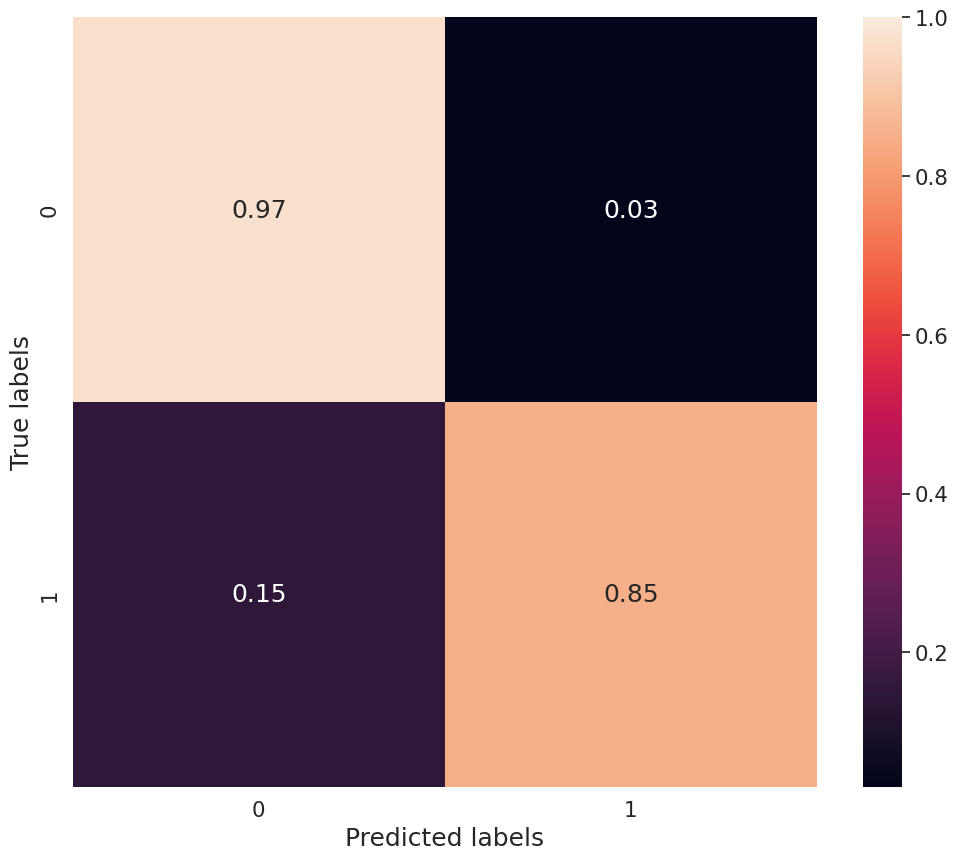

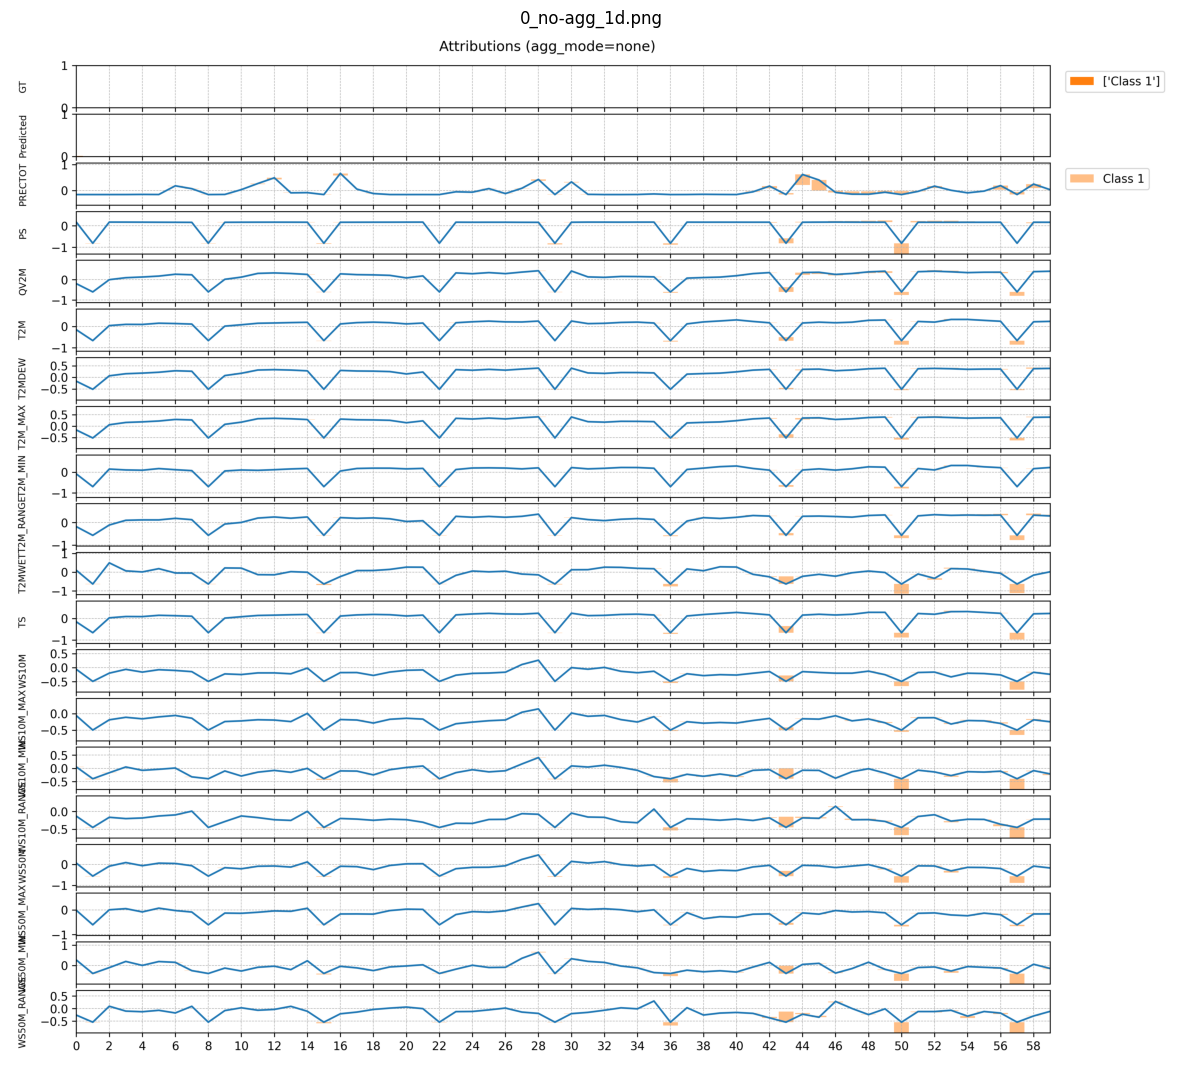

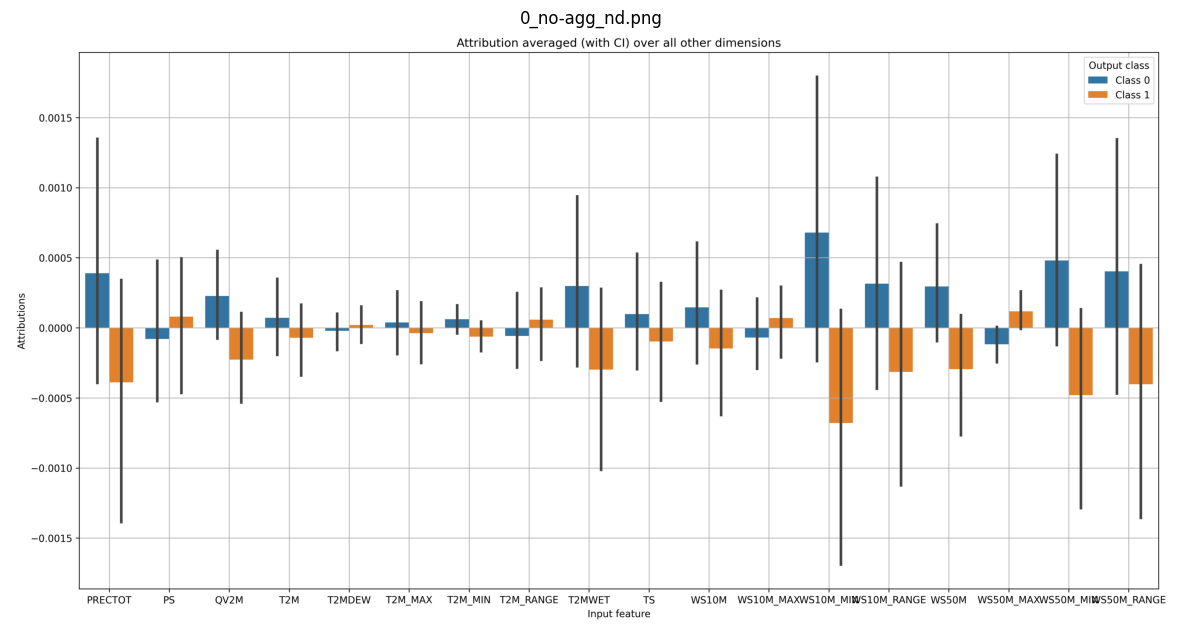

In [17]:
event_name= xai_output['event_names'][0]
paths= list((Path(classifier.config['save_path']) / 'xai').glob(f'{event_name}*.png'))
for path in paths:
    img= np.asarray(Image.open(path))
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.axis(False);
    plt.title(path.name)
    plt.show()